# Search TSX Shape File Catalog to Find Frames that Contain a Point
---

This notebook lets the user search of all frames tha contain a point, and then further narrow the selection based on attributes like date, mode, track, etc. The results are saved in a shape file. 

The procedure will work best if you first identify the lat/lon coordinates for your area of interest and then verify that data exist for that point either using the legacy tool or viewing the shape file arcgis or qgis.

Experienced users, hack away as needed.

For inexperienced users most types of searches can be carried out by:
- use the run button (triangle) to advance through the cells until the **User Defined Parameters** section. 
- Adjust the parameters as needed and run the cell. 
- Advance through Step 1.
- Based on Step 1 results, decide on how to modify parameters (e.g., select mode, rel_orbit, ascending/descending).
- Go back to **User Defined Parameters**, modify parameters as needed, and rerun the cell.
- Run Step 2 and decide if incidence angle needs refining (if not set to large values (e.g., 0-100)
- Run Step 3 (even if ignoring incidence angle).
- If looking for insar pairs and the search has been narrowed to a single swath, set **dtThresh** in the parameters section to the maximum temporal baseline.
- If not interested in insar, set **dtThresh** to 1e6 to pass all pairs.
- Run Step 4 through the rest of the notebook.

Run all steps, even if some parameters are set so they won't do anything.

Running the original notebook with no changes to the end will run an example search on an Alaskan glacier.

Contact Ian Joughin (irj@uw.edu) with question, comments, or suggestions for improvement.

## Python Setup Stuff

In [1]:
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import pyproj
import contextily as ctx
import simplekml

Setup transform for plotting points in map coordinates used by contextily.

In [2]:
mapProjection = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')).transform
invMapProjection = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326')).transform

In [3]:
def formatDate(dateString):
    ''' Convert date string for a column to date time values'''
    return np.array([datetime.strptime(x,'%Y-%m-%d') for x in dateString])

In [4]:
def filterDate(myDB, firstDate, lastDate):
    ''' Filter tsxDB by date range '''
    dates = formatDate(myDB['start_time']) 
    return myDB[np.logical_and(dates >= firstDate, dates <= lastDate)].sort_values(by='start_time')

In [5]:
def searchCircle(lat, lon, radius):
    pxy = Point(transform(mapProjection, Point(lat, lon)).coords[:][0])
    xyCircle = pxy.buffer(radius * 2 * 1000)
    llCircle = transform(invMapProjection, xyCircle)
    # Swap lat/lon for different convention used by pandas
    llCircle = Polygon([(x[1], x[0]) for x in llCircle.exterior.coords[:]])
    return llCircle, xyCircle

def filterRadius(myDB, lat, lon, radius):
    ''' Find tracks that contain a point'''
    llCircle, _ = searchCircle(lat, lon, max(radius, 1))
    return myDB[myDB['geometry'].intersects(llCircle)]

In [6]:
def filterProperties(myDB, properties):
    ''' Filter on a dictionary of properties '''
    result = myDB
    for key in properties:
        if properties[key] is not None:
            result = result[result[key] == properties[key]]
    return result

In [7]:
def filterIncidence(myDB, incMin, incMax):
    ''' Filter by incidence angle range'''
    return myDB[np.logical_and(myDB['inc_min'] >= incMin, myDB['inc_max'] <= incMax)]

In [8]:
def plotSearch(myResult, lat, lon, radius, zoom=10, **keywords):
    ''' Plot the search results '''
    ax = myResult.to_crs(epsg=3857).plot(facecolor='none', linewidth=2, **keywords)
    ax.set_aspect('equal')
    ctx.add_basemap(ax, zoom=zoom)
    _, xyCircle = searchCircle(lat, lon, max(radius, 3))
    x, y = xyCircle.exterior.xy
    ax.plot(x, y, 'r', linewidth=2)
    return ax

In [9]:
def saveAOI(lat, lon, radius, fileName):
    ''' Save AOI (circle with radius centered on lat/lon) as kmz'''
    ll, _ = searchCircle(lat, lon, radius)
    kml = simplekml.Kml()
    pol = kml.newpolygon(name='AOI')
    pol.outerboundaryis = ll.exterior.coords[:]
    pol.style.linestyle.width = 3
    pol.style.polystyle.color= simplekml.Color.changealphaint(100, simplekml.Color.red)
    kml.savekmz(fileName)
    print(f'AOI saved as: {fileName}')

## Read and Filter TSX Database

The following steps will read the catalog, apply various filters, and plot intermediate and final results.

### Read Catalog

This step reads the catlog and displays the first line to show the column headings. For running within **binder** memory limits, this call loads **cat0Polygon.Reduced.zip**, which has a reduced set of columns. If running on a local machine and the additional data are needed, load **cat0Polygon.zip**. Note this will slow the read so only use if needed.

In [10]:
tsxDB = gpd.read_file('zip://cat0Polygon.Reduced.zip') 
tsxDB.head(1)

,id,mission,img_mod,inc_min,inc_max,abs_orbit,rel_orbit,looking_di,pol_mod,path_dir,start_time,geometry
0,TSX-1_2013-12-21T11_59_5203165,TSX-1,Stripmap (SM),33.010539,34.500304,36154,82,R,Dual Polarisation (D),descending,2013-12-21,"POLYGON ((-88.97313 29.28657, -88.80256 29.259..."


### Define search params (All User Defined Parameters at This Step)

**Everything needed to define the search is specified in this cell.** The notebook may need to be run once or twice to pick the final values based on the intermediate results. For example, the relative orbit should be picked after the first step to narrow by location and time. Likewise the incidence angle after seeing the range of incidence angles.

The search is carried out in a series of steps. In general, after running the first step or two, these parameters need to be adjusted to refine the search. For example, after running step 1, adjust parameters such as **rel_orbit** to select a particular track.

In [11]:
# Step 1 time and date
lat, lon = 58.587, -133.969  # Find frames that contain this point
radius = 25  # Change set to a value > 0 for non-point search
firstDate, lastDate = datetime(2009,1,1), datetime(2015,12,31)  # Find frames in this date range
# Step 2 properties
properties = {'img_mod': 'Stripmap (SM)',  # Imaging mode
              'looking_di': 'R',   # Lookdir, almost always R for right
              'path_dir': 'ascending',  # ascending or descending
              'pol_mod': None,  # Polarization mode
              'rel_orbit': 137}     # relative orbit
# Step 3 incidence Angle Range
incidenceAngleMin = 34.
incidenceAngleMax = 40. 
# Step 4 temporal baseline (set to large number f)
dTthresh = 22  # Maximum temporal spacing for insar pairs - change to None if not applicable
# Output file
resultsFile = 'TakuGlacier.137.shp'  # The name of the file with results (end with .shp for shape file and .csv for csv)
#
processingLevel = 'SSC'  # Important - make sure the desired deliver format is specified (SSC, MGD, GEC, EEC)

Check to make sure parameters specified are valid. Go back and fix any errors that are flagged, otherwise proceed.

In [12]:
# Check properties
for key in properties:
    if key not in tsxDB.columns:
        print(f'*** Property {key} is not valid ***')
# Check filename
if not resultsFile.endswith('.csv') and not resultsFile.endswith('.shp'):
    print(f'*** Results File, {resultsFile}, should end with .csv or .shp ***')

### Step 1: Narrow By Location and Time

For this stage, the data based is narrowed by time and location so that all tracks over the desired point and during the desired interval are displayed. If this takes too long to run, try reducing zoom value for *plotSearch*. Subsequent steps should be faster.

The legend specifies the relative orbit. To downselect to a particular orbit, edit **rel_orbit** above, rerun that cell, and proceed to Step 2.

Search returned 57 products


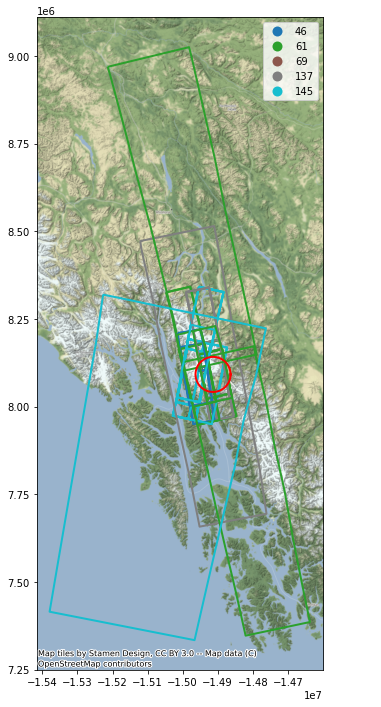

In [13]:
myResultSpace = filterRadius(tsxDB, lat, lon, radius)  # Narrow by Location
myResultTime = filterDate(myResultSpace, firstDate, lastDate)  # Narrow by date range
plotSearch(myResultTime, lat, lon, radius, zoom=8, column='rel_orbit', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultTime.shape[0]} products')

### Step 2: Search by Properties

This further narrows the search using a dictionary of properties (e.g., relative orbit, ascending or descending, mode etc). This is a good place to narrow down to a single relative orbit (track). The remaining results are then listed by incidence angle.

Search returned 15 products


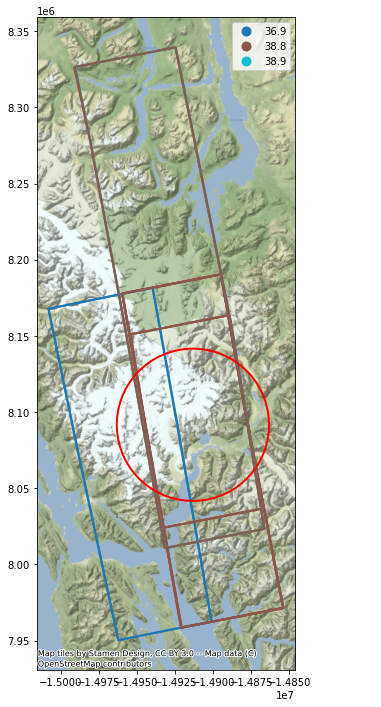

In [14]:
myResultProperties = filterProperties(myResultTime, properties)  # Narrow by properties
myResultProperties['inc_max'] = myResultProperties['inc_max'].round(1)  # Round the result to avoid to many legend entries
plotSearch(myResultProperties, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultProperties.shape[0]} products')

### Step 3: Reduce by Incidence Angle

If the results have been narrowed down to a single relative orbit (track), then there may be multiple swaths for that track. Here the results can be refined to a single swath using the incidence angle range.

Search returned 13 products


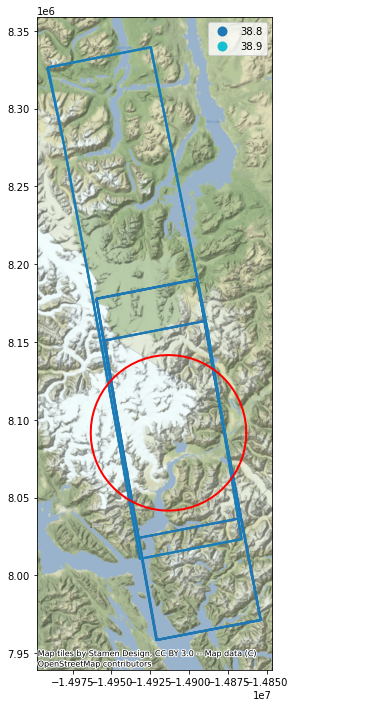

In [15]:
myResultAngle = filterIncidence(myResultProperties, incidenceAngleMin, incidenceAngleMax)
plotSearch(myResultAngle, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultAngle.shape[0]} products')

### Step 4: Filter for Interferometric Pairs

This step will eliminate images that don't belong to a pair with seperation of dTthresh days or less. If dThresh=None, it will save the result as final with no change. Note, the incidence angle may deviate by 0.1 or so degrees for the same swath.

Search returned 12 products


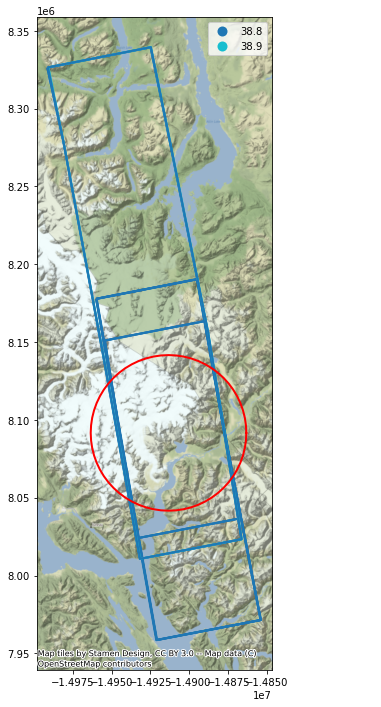

In [16]:
if dTthresh is not None:
    dates = formatDate(myResultAngle['start_time'])
    forwards = [ (dates[i+1] - dates[i]).days <= dTthresh for i in range(0,len(dates)-1)] + [False] # check forward in time pairs
    backwards = [False] + [ (dates[i] - dates[i-1]).days <= dTthresh for i in range(1,len(dates))] # check backwards in time pairs
    keep = np.logical_or(forwards, backwards)  #  Union of all valid pairs.
    myResultFinal = myResultAngle[keep]  # Remove invalid images
else:
    myResultFinal = myResultAngle  # No change
plotSearch(myResultFinal, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultFinal.shape[0]} products')

 ### Step 5: Summarize and Save Results

List final results.

In [17]:
myResultFinal[['id', 'mission', 'abs_orbit', 'rel_orbit', 'start_time']].sort_values(by='start_time')

,id,mission,abs_orbit,rel_orbit,start_time
89846,TSX-1_2009-06-08T02_31_4084044,TSX-1,10992,137,2009-06-08
85815,TSX-1_2009-06-19T02_31_4155156,TSX-1,11159,137,2009-06-19
177276,TSX-1_2009-07-11T02_31_4231887,TSX-1,11493,137,2009-07-11
92918,TSX-1_2009-07-22T02_31_4289507,TSX-1,11660,137,2009-07-22
80261,TSX-1_2009-08-13T02_31_446783,TSX-1,11994,137,2009-08-13
177210,TSX-1_2010-07-09T02_31_5338313,TSX-1,17004,137,2010-07-09
80829,TSX-1_2010-07-20T02_31_5377445,TSX-1,17171,137,2010-07-20
79305,TSX-1_2010-08-11T02_31_5490849,TSX-1,17505,137,2010-08-11
88888,TDX-1_2011-07-07T02_31_5703931,TDX-1,5785,137,2011-07-07
90439,TSX-1_2011-07-29T02_31_5846924,TSX-1,22849,137,2011-07-29


Write the result to a csv or shapefile.

In [18]:
if resultsFile.endswith('csv'):
    myResultFinal.to_csv(resultsFile)
else:
    myResultFinal.to_file(resultsFile)

Save the circle used in the search as the AOI.

In [19]:
baseName = '.'.join(resultsFile.split('.')[0:-1])
aoiFile = f'{baseName}.kmz'
saveAOI(lat, lon, radius, aoiFile)

AOI saved as: TakuGlacier.137.kmz


Print the data in a format for the AIRBUS order form. These data can be copied into the spread sheet directly. At first the each line will occupy a single column. Go to the data tab, select "text to columns", selected "delimited", then "comma", followed by "finish". 

In [20]:
for row in myResultFinal.iterrows():
    print(f'{row[1]["mission"]}, {row[1]["id"]}, {processingLevel}, {row[1]["img_mod"]}, Yes, {aoiFile}')

TSX-1, TSX-1_2009-06-08T02_31_4084044, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2009-06-19T02_31_4155156, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2009-07-11T02_31_4231887, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2009-07-22T02_31_4289507, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2009-08-13T02_31_446783, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2010-07-09T02_31_5338313, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2010-07-20T02_31_5377445, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2010-08-11T02_31_5490849, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TDX-1, TDX-1_2011-07-07T02_31_5703931, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2011-07-29T02_31_5846924, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TSX-1, TSX-1_2011-08-09T02_31_5865032, SSC, Stripmap (SM), Yes, TakuGlacier.137.kmz
TDX-1, TDX-1_2011-08-20T02_31_5914012, SSC, Stripmap (SM), Yes, TakuGlacier.1

Consolodate all results in to a single zip file. 

**Binder users should download this file before the machine times out (find file in file browser in the righthand column, right click, and select download).**

In [21]:
!zip {baseName}.zip {baseName}.*

updating: TakuGlacier.137.cpg (stored 0%)
updating: TakuGlacier.137.dbf (deflated 91%)
updating: TakuGlacier.137.kmz (stored 0%)
updating: TakuGlacier.137.prj (deflated 17%)
updating: TakuGlacier.137.shp (deflated 40%)
updating: TakuGlacier.137.shx (deflated 51%)


In [22]:
print(f'Results saved as {baseName}.zip')

Results saved as TakuGlacier.137.zip
